In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from WGAN import Critic, Generator, init_model
import torchvision.transforms as tr

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

In [14]:
IMG_SIZE = 64
EPOCHS = 50
IMG_CHANNELS = 3
BATCH_SIZE = 64
Z_DIM = 3
LEARNING_RATE = 5e-5
FEATURE_GENERATOR = FEATURE_DISCRIMINATOR = 64
CRITIC_ITER = 5
WEIGHT_CLIP = 0.01

In [5]:
transform = tr.Compose([
    tr.Resize((IMG_SIZE, IMG_SIZE)),
    tr.ToTensor(),
    tr.Normalize([0.5 for _ in range(IMG_CHANNELS)], [0.5 for _ in range(IMG_CHANNELS)]),
])

In [6]:
data = ImageFolder('./datasets/Celeba/', transform=transform)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [16]:
gen = Generator(Z_DIM, IMG_CHANNELS, FEATURE_GENERATOR).to(device)
critic = Critic(IMG_CHANNELS, FEATURE_DISCRIMINATOR).to(device)

init_model(gen)
init_model(critic)

optimizer_gen = torch.optim.RMSprop(gen.parameters(), lr = LEARNING_RATE)
optimizer_disc = torch.optim.RMSprop(critic.parameters(), lr = LEARNING_RATE)

In [17]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)
writer_fake = SummaryWriter('./runs/WGAN/fake')
writer_real = SummaryWriter('./runs/WGAN/real')

In [18]:
gen.train()
critic.train()

Critic(
  (dis): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [19]:
step = 0

In [20]:
for epoch in tqdm(range(EPOCHS)):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device) 


        # Train Critic
        for _ in range(CRITIC_ITER):
            noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
            fake = gen(noise)   
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake.detach()).reshape(-1)
            loss_critic = -(torch.mean(critic_real) - torch.mean(critic_fake))
            optimizer_disc.zero_grad()
            loss_critic.backward()
            optimizer_disc.step()

            for p in critic.parameters():
                p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)

        # Train Generator 
        out = critic(fake).reshape(-1)
        loss_gen = -torch.mean(out)
        optimizer_gen.zero_grad()
        loss_gen.backward()
        optimizer_gen.step()

        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{EPOCHS}] Batch [{batch_idx}/{len(dataloader)}] \
                    Loss D: {loss_critic:.4f}, Loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image('Real', img_grid_real, global_step=step)
                writer_fake.add_image('Fake', img_grid_fake, global_step=step)
            step += 1

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [0/50] Batch [0/50]                     Loss D: -0.0711, Loss G: 0.0143
Epoch [1/50] Batch [0/50]                     Loss D: -1.4817, Loss G: 0.6855
Epoch [2/50] Batch [0/50]                     Loss D: -1.5204, Loss G: 0.7078
Epoch [3/50] Batch [0/50]                     Loss D: -1.5298, Loss G: 0.7117
Epoch [4/50] Batch [0/50]                     Loss D: -1.5315, Loss G: 0.7125
Epoch [5/50] Batch [0/50]                     Loss D: -1.5333, Loss G: 0.7126
Epoch [6/50] Batch [0/50]                     Loss D: -1.5340, Loss G: 0.7129
Epoch [7/50] Batch [0/50]                     Loss D: -1.5343, Loss G: 0.7128
Epoch [8/50] Batch [0/50]                     Loss D: -1.5351, Loss G: 0.7129
Epoch [9/50] Batch [0/50]                     Loss D: -1.5326, Loss G: 0.7123
Epoch [10/50] Batch [0/50]                     Loss D: -1.5265, Loss G: 0.7078
Epoch [11/50] Batch [0/50]                     Loss D: -1.5237, Loss G: 0.7092
Epoch [12/50] Batch [0/50]                     Loss D: -1.5214

KeyboardInterrupt: 

#### Now let's take a look on pictures

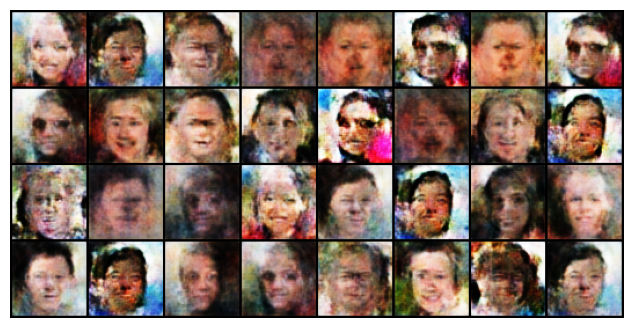

In [21]:
fake_img = gen(fixed_noise).detach().cpu()

fake_img_grid = torchvision.utils.make_grid(fake_img, normalize=True)

plt.figure(figsize=(14, 4))
plt.imshow(fake_img_grid.permute(1, 2, 0))
plt.axis("off")
plt.show()